In [1]:
import sys
sys.path.append('..')

import numpy as np
from tqdm.auto import tqdm

from olfactory_navigation import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.simulation import run_test

# Loading Environment

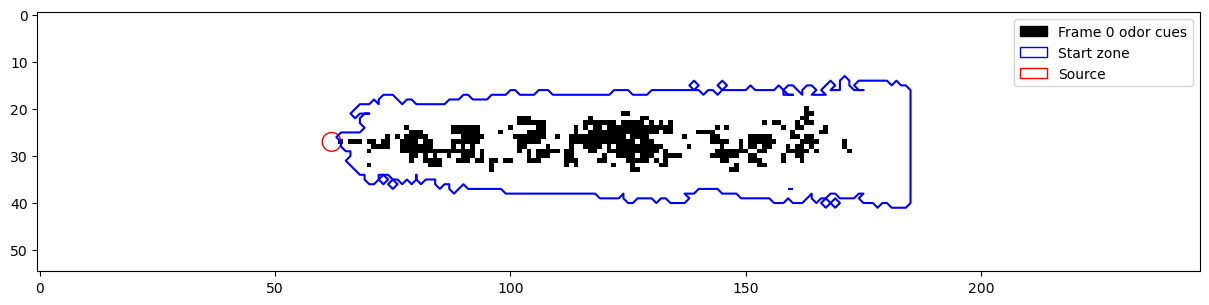

In [2]:
# data_file = "C:\\Users\\arnau\\Desktop\\Master Thesis Files [TO BACKUP]\\Data\\nose_data.npy"
data_file = "/storage/rando/data/nose_data.npy"

full_env = Environment(data_file=data_file,
                       data_source_position=[143,0],
                       source_radius=2,
                       shape=np.array([55,247]),
                       margins=[14,62],
                       boundary_condition='wrap_vertical',
                       start_zone='odor_present',
                       odor_present_threshold=3e-6
                       )

full_env.plot()

In [3]:
ag = FSVI_Agent(full_env)

[05/31/2024, 13:32:05] Instantiation of MDP Model:
[05/31/2024, 13:32:05] - 13585 states
[05/31/2024, 13:32:05] - 4 actions
[05/31/2024, 13:32:05] - At most 1 reachable states per state-action pair
[05/31/2024, 13:32:05] - Starting generation of transitions table
[05/31/2024, 13:32:05]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[05/31/2024, 13:32:05]     > Done in 0.000s
[05/31/2024, 13:32:05] - Generation of state grid
[05/31/2024, 13:32:05] - Generating start probabilities table
[05/31/2024, 13:32:05] - Starting computation of reachable state probabilities from transition data
[05/31/2024, 13:32:05]     > Done in 0.000s

[05/31/2024, 13:32:05] POMDP particular parameters:
[05/31/2024, 13:32:05] - 3 observations
[05/31/2024, 13:32:05] - Starting of transitional observations for reachable states table
[05/31/2024, 13:32:05]     > Done in 0.002s
[05/31/2

In [4]:
_ = ag.train(expansions=300, force=True, use_gpu=True)

[05/31/2024, 13:32:06] MDP_policy, not provided. Solving MDP with Value Iteration...
[05/31/2024, 13:32:06] Sending Model to GPU...
[05/31/2024, 13:32:07]     > Done in 1.014s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 13585-state, 4-action
  - Converged in 918 iterations and 0.6463 seconds
  - Took on average 0.0007s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 13585 state, 4 action, 3 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Resulting value function has 2136 alpha vectors.
  - Converged in 22.0330s

  - Expand function took on average 0.0082s and yielded on average 677.20 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 0.0652s and yielded on average 7.11 alpha vectors per iteration. (0.0003s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


In [5]:
# Function variables
agent = ag

step_perc = 20
min_perc = 20
max_perc = 300

# Gather environment
environment = agent.environment

# Gathering starting points
start_points = np.argwhere(environment.start_probabilities > 0)
n = len(start_points)

# Generating multipliers
with np.errstate(divide='ignore'):
    low_max_mult = ((environment.margins[:,0] / environment.data_source_position) + 1)
    high_max_mult = (1 + (environment.margins[:,1] / (environment.data_shape - environment.data_source_position)))
    max_mult = np.min(np.vstack([low_max_mult, high_max_mult]), axis=0)

multipliers = [(100 - perc_mult) for perc_mult in range(0, (100-min_perc)+step_perc, step_perc)[1:]] + [perc_mult for perc_mult in range(100, min(max_perc, int(max(max_mult)*100)), step_perc)]
multipliers.sort()

# Generating all combinations of multipliers
mult_combinations = np.array(np.meshgrid(multipliers, multipliers, indexing='xy')).T.reshape(-1,2).astype(float)
mult_combinations /= 100
mult_combinations = mult_combinations[np.all(mult_combinations < max_mult, axis=1), :]

for mults in tqdm(mult_combinations):
    print(f'Testing on environment with height {int(mults[0]*100)}% and width {int(mults[1] * 100)}%')
    
    # Modifying environment
    modified_environment = environment.modify(multiplier=mults)

    # Running test
    hist = run_test(
        agent=agent,
        n=n,
        start_points=start_points,
        environment=modified_environment,
        print_progress=False,
        print_stats=True,
        use_gpu=True)

    # break
    print()

  0%|          | 0/63 [00:00<?, ?it/s]

Testing on environment with height 20% and width 20%
Using the provided environment, not the agent environment.
Simulations done in 9.899s:
Simulations reached goal: 1456/2393 (937 failures) (60.84%)
	- Average step count: 502.746 +- 408.88 (Successfull only: 182.741 +- 115.13)
	- Extra steps: 431.712 +- 409.82 (Successful only: 107.299 +- 81.97)
	- Average discounted rewards (ADR): 0.169 +- 0.24 (Successfull only: 0.277 +- 0.26)
	- Tmin/T: 0.316 +- 0.23 (Successful only: 0.479 +- 0.15)

Testing on environment with height 20% and width 40%
Using the provided environment, not the agent environment.
Simulations done in 7.793s:
Simulations reached goal: 1790/2393 (603 failures) (74.80%)
	- Average step count: 360.936 +- 379.25 (Successfull only: 145.653 +- 91.45)
	- Extra steps: 289.902 +- 376.86 (Successful only: 73.251 +- 58.39)
	- Average discounted rewards (ADR): 0.246 +- 0.26 (Successfull only: 0.329 +- 0.25)
	- Tmin/T: 0.428 +- 0.24 (Successful only: 0.549 +- 0.14)

Testing on envir